# Car Insurance Claim Prediction (Driver Profile Dataset)

This notebook analyzes the Kaggle driver profile dataset and builds two baseline models:
- Logistic Regression
- Random Forest

We will:
- Load and audit the data (schema, balance, missingness)
- Visualize key distributions BEFORE any filtering
- Prepare a leakage-aware preprocessing pipeline (target-encode `POSTAL_CODE`, OHE other categoricals, impute missing values)
- Train and evaluate Logistic Regression and Random Forest


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    accuracy_score, log_loss, precision_recall_curve
)
sns.set_context("talk")
plt.rcParams["figure.figsize"] = (8,5)


In [2]:
df = pd.read_csv('Car_Insurance_Claim.csv')
print(df.shape)
df.head(3)

(10000, 19)


,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

In [4]:
print('Outcome distribution:')
print(df['OUTCOME'].value_counts())
print('\nOutcome rate:', df['OUTCOME'].mean().round(3))

Outcome distribution:
OUTCOME
0.0    6867
1.0    3133
Name: count, dtype: int64

Outcome rate: 0.313


## Missingness overview
We will visualize missing values before deciding on any imputations.

CREDIT_SCORE      9.8
ANNUAL_MILEAGE    9.6
dtype: float64


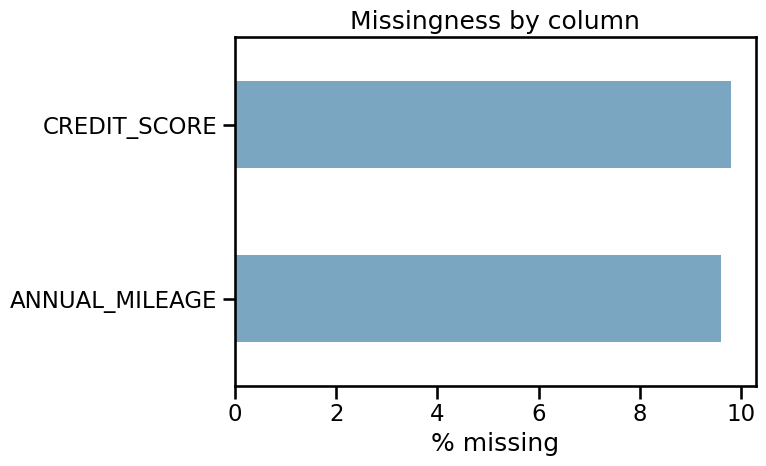

In [5]:
mis = df.isna().mean().sort_values(ascending=False)
mis = (mis[mis>0]*100).round(1)
print(mis)
ax = mis.plot(kind='barh', color='#7aa6c2')
ax.set_xlabel('% missing')
ax.set_title('Missingness by column')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Numeric distributions
Visualize numeric features to understand scale, skew and potential outliers.


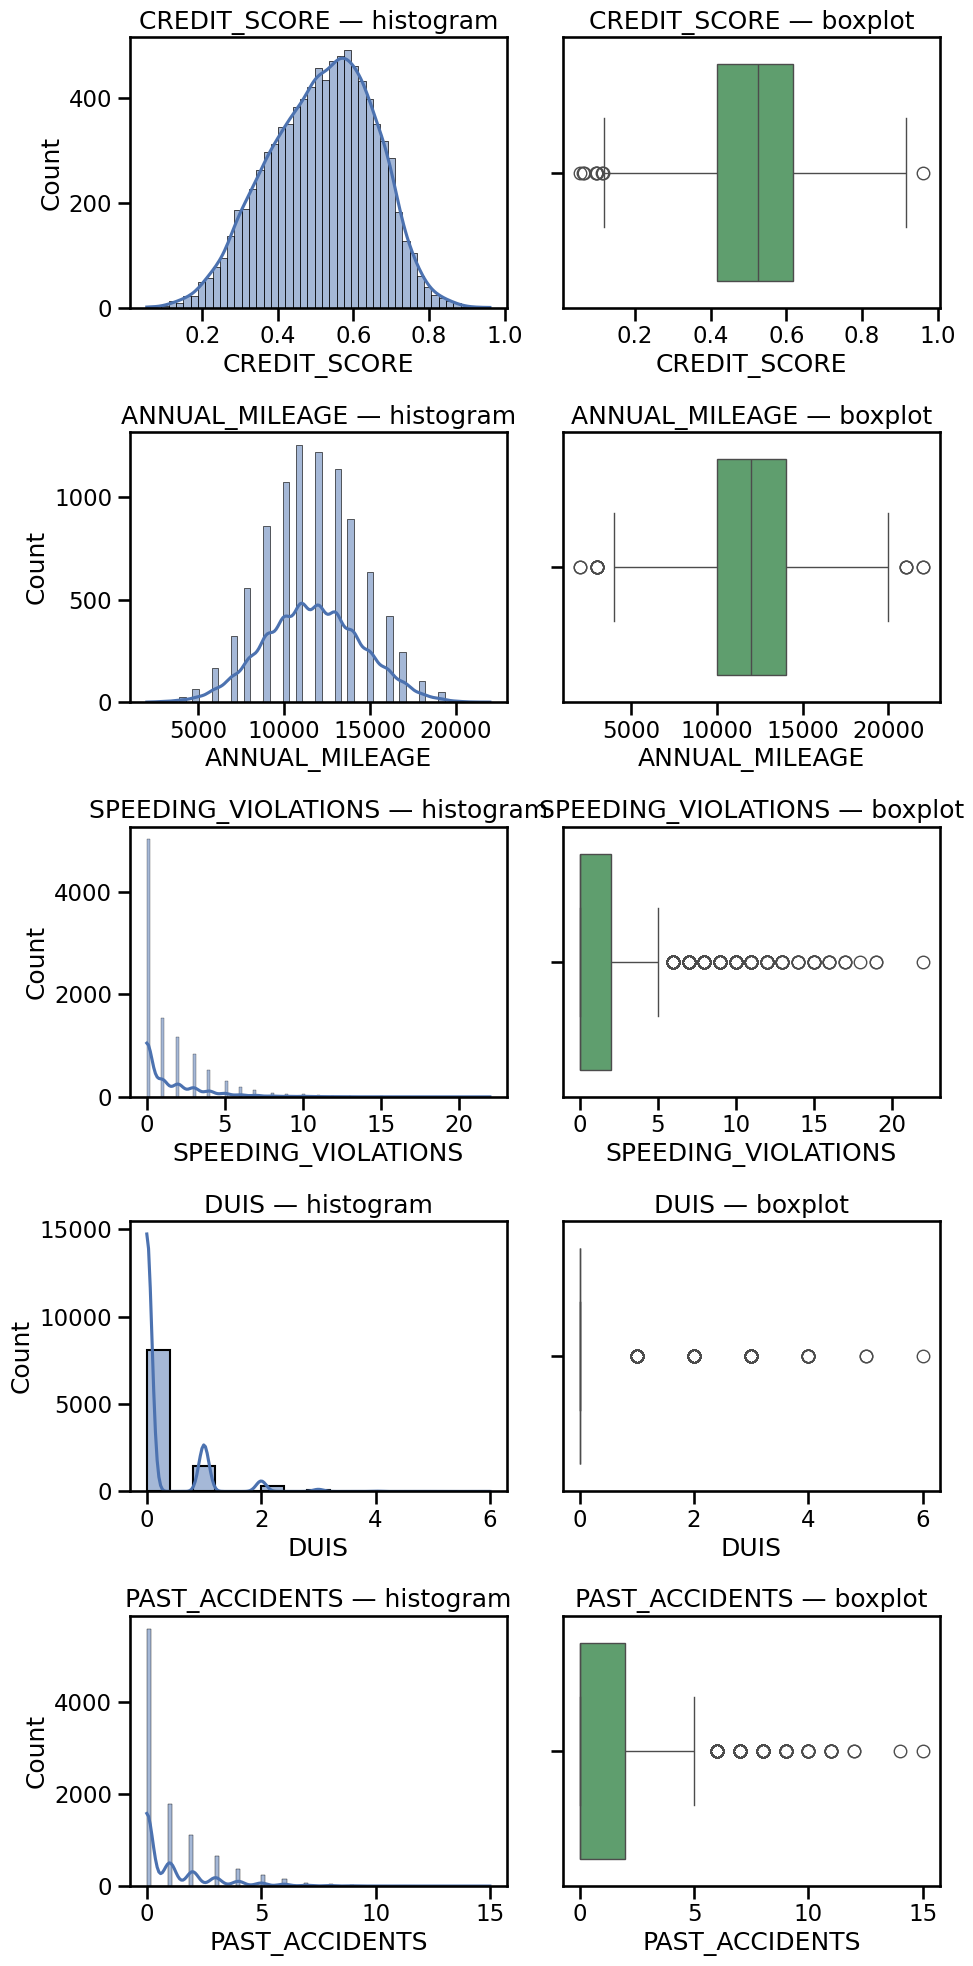

In [6]:
num_cols = ['CREDIT_SCORE','ANNUAL_MILEAGE','SPEEDING_VIOLATIONS','DUIS','PAST_ACCIDENTS']
num_cols = [c for c in num_cols if c in df.columns]
fig, axes = plt.subplots(len(num_cols), 2, figsize=(10, 4*len(num_cols)))
for i, c in enumerate(num_cols):
    sns.histplot(df[c], kde=True, ax=axes[i,0], color='#4C72B0')
    axes[i,0].set_title(f'{c} — histogram')
    sns.boxplot(x=df[c], ax=axes[i,1], color='#55A868')
    axes[i,1].set_title(f'{c} — boxplot')
plt.tight_layout()
plt.show()


## Categorical distributions
Plot counts for key categorical features.

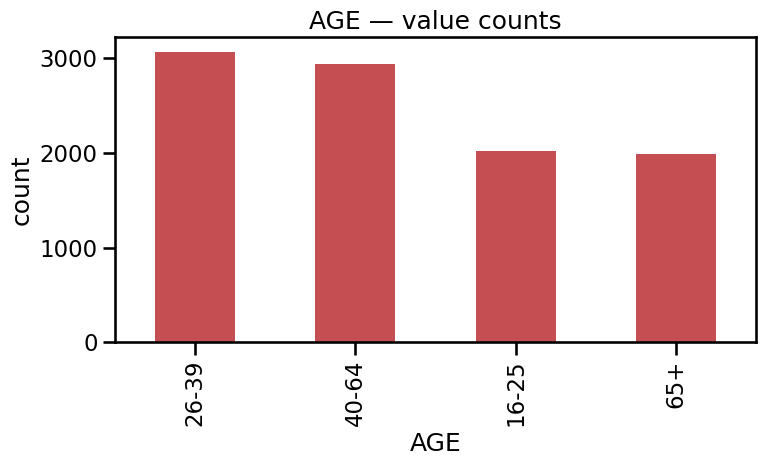

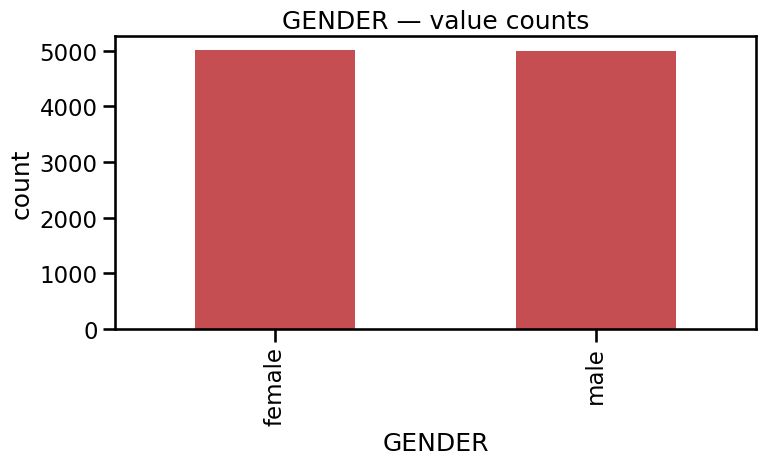

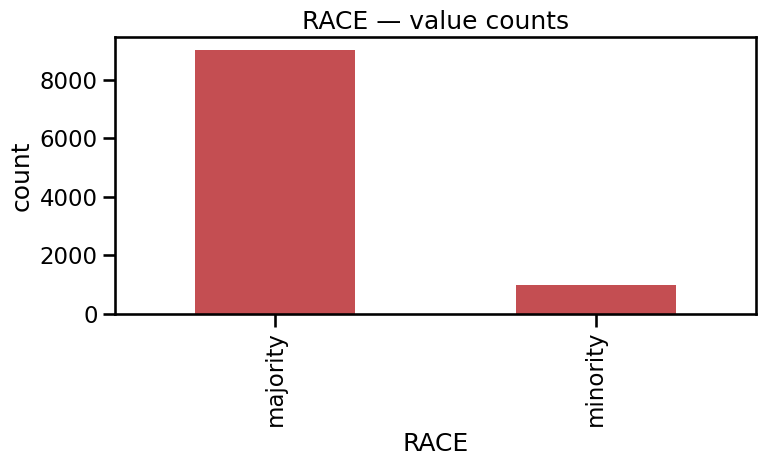

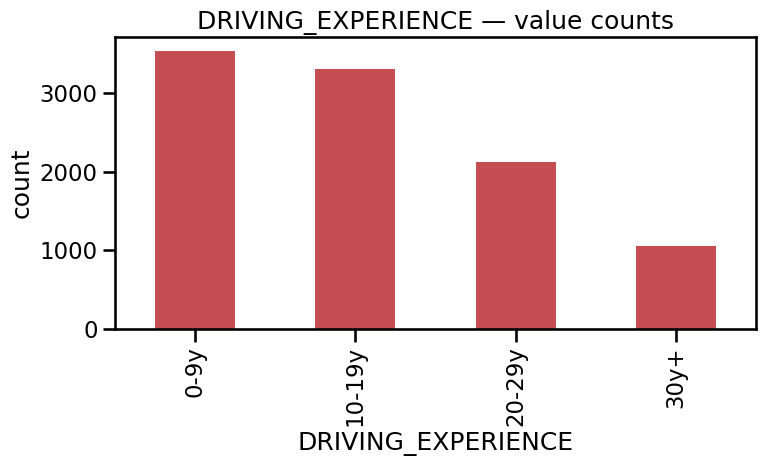

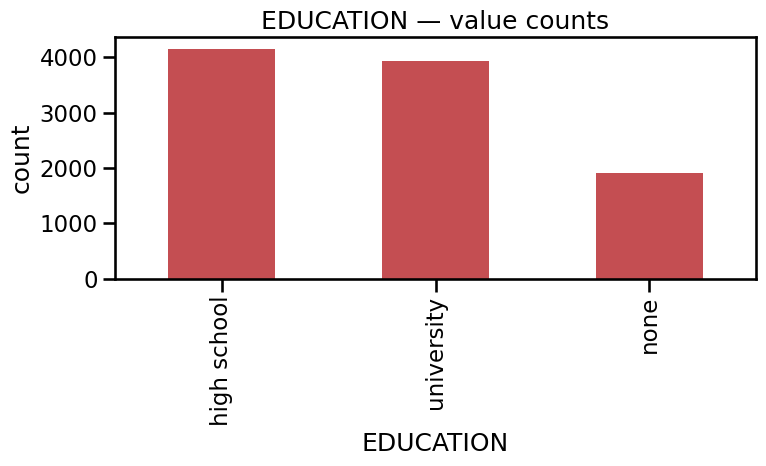

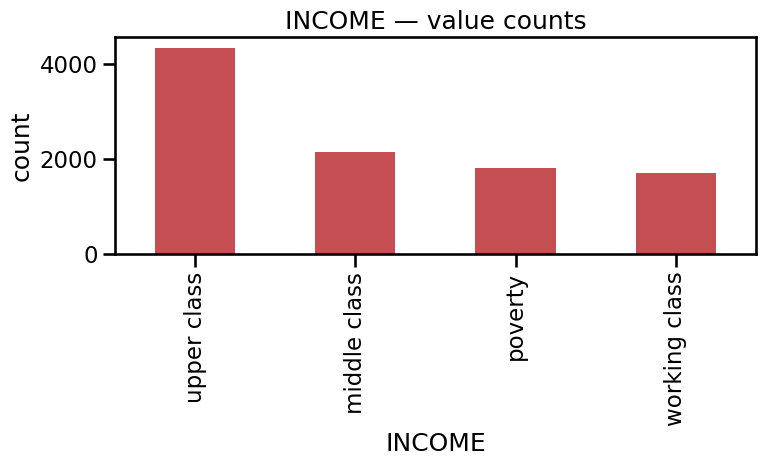

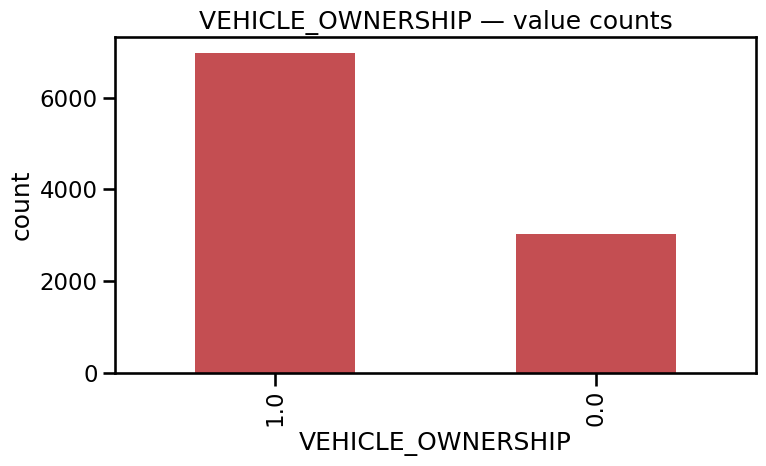

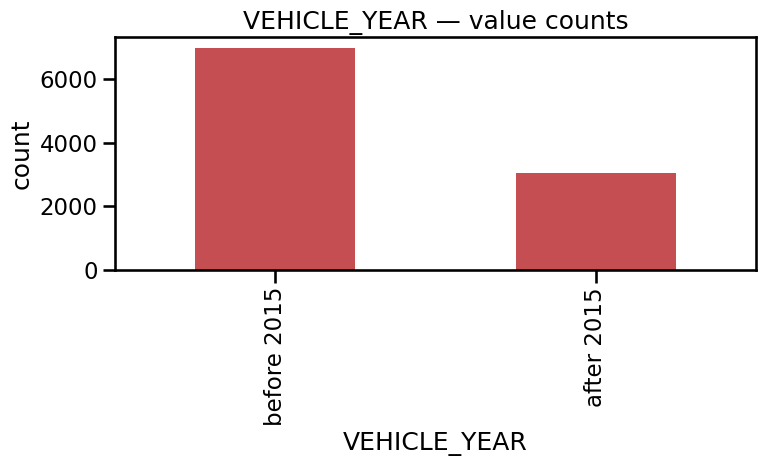

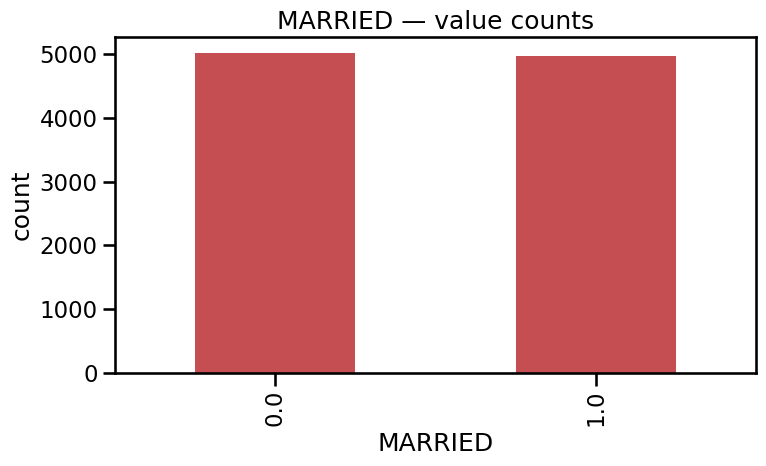

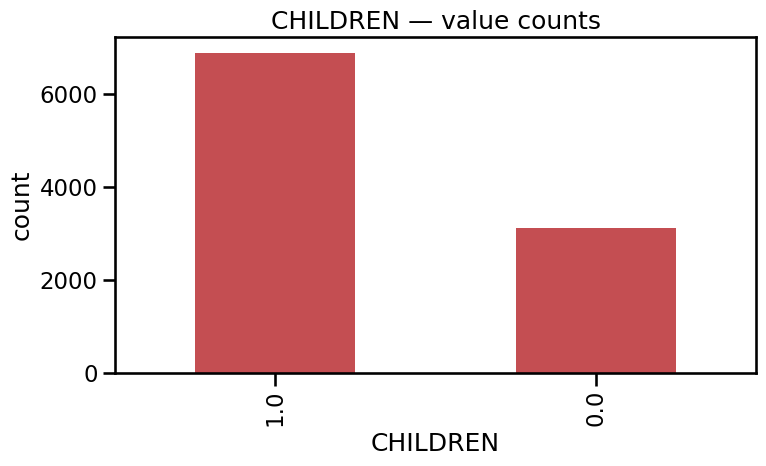

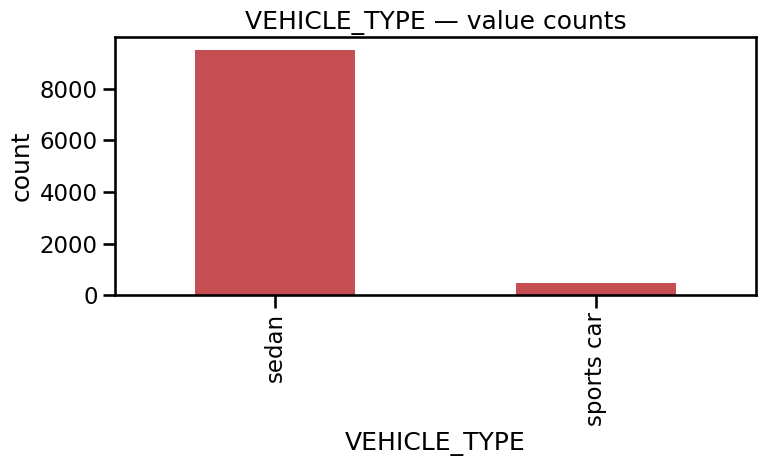

In [7]:
cat_cols = ['AGE','GENDER','RACE','DRIVING_EXPERIENCE','EDUCATION','INCOME','VEHICLE_OWNERSHIP','VEHICLE_YEAR','MARRIED','CHILDREN','VEHICLE_TYPE']
cat_cols = [c for c in cat_cols if c in df.columns]
for c in cat_cols:
    ax = df[c].value_counts().plot(kind='bar', color='#c44e52')
    ax.set_title(f'{c} — value counts')
    ax.set_xlabel(c)
    ax.set_ylabel('count')
    plt.tight_layout()
    plt.show()


## Outcome rate by category (risk plotting)
Visualize claim rate (`OUTCOME` mean) across categories to spot strong signals.

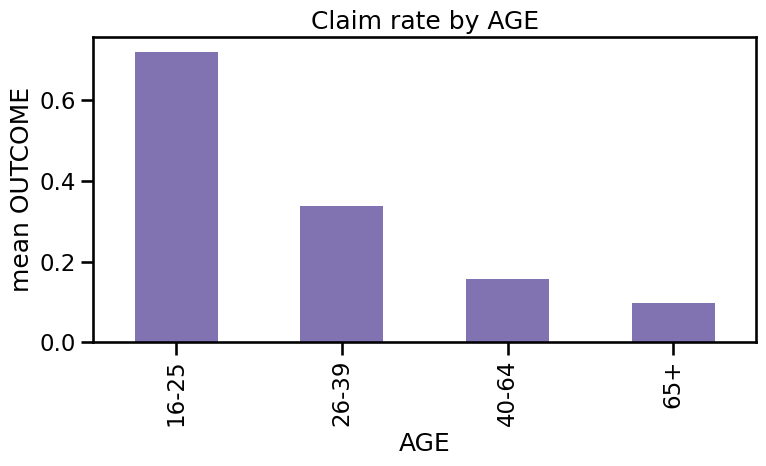

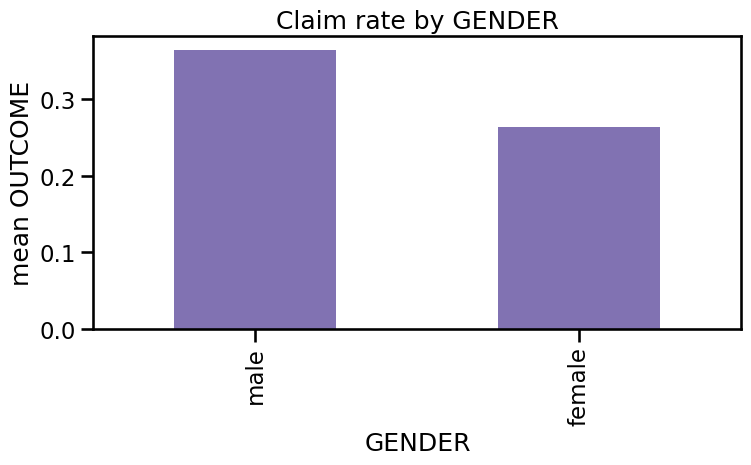

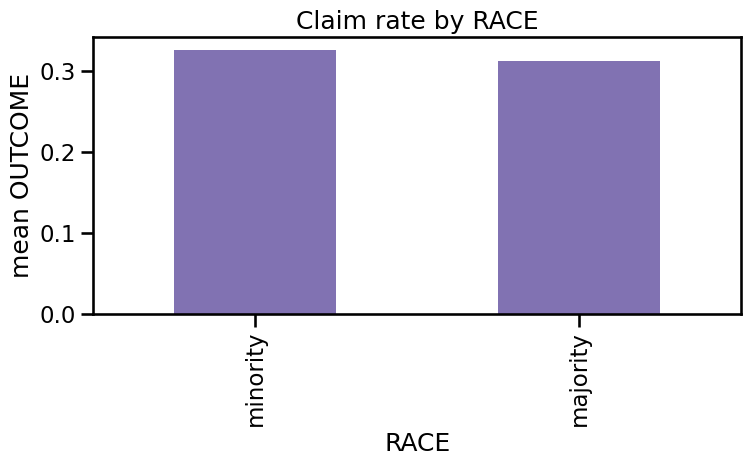

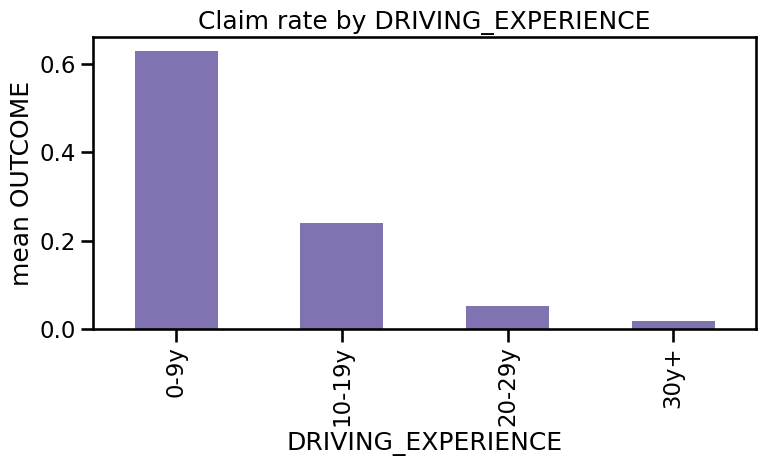

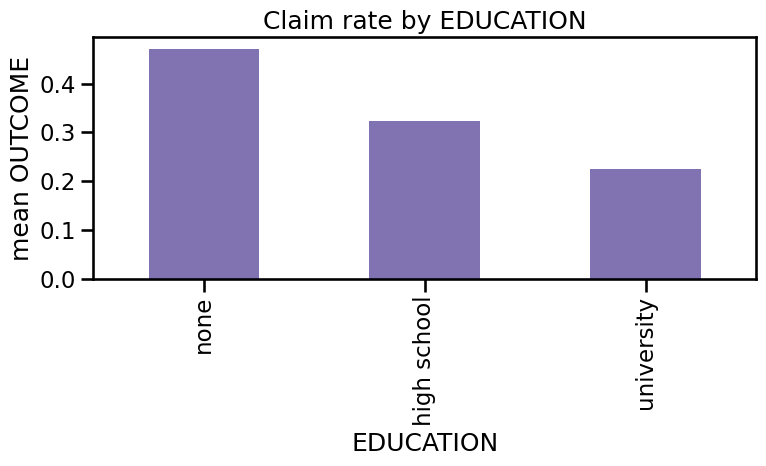

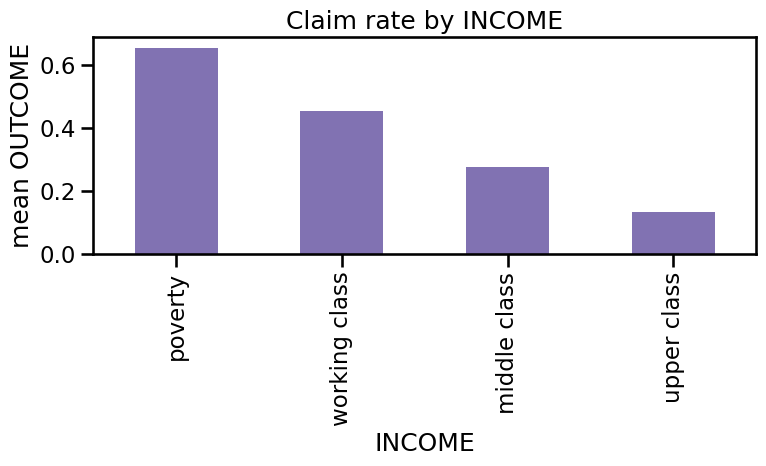

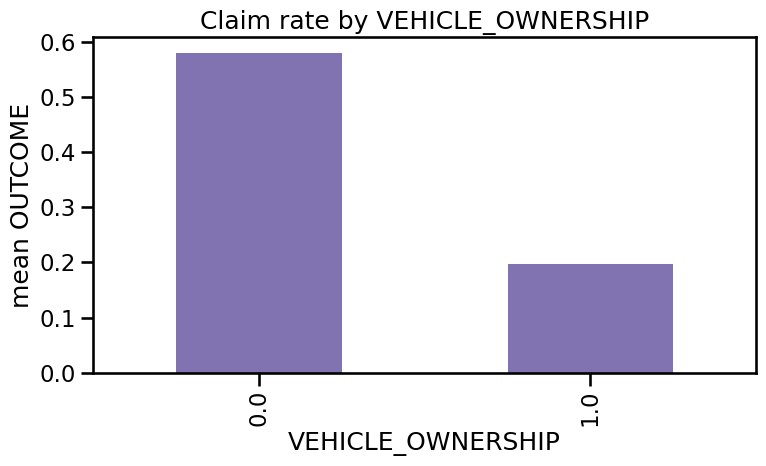

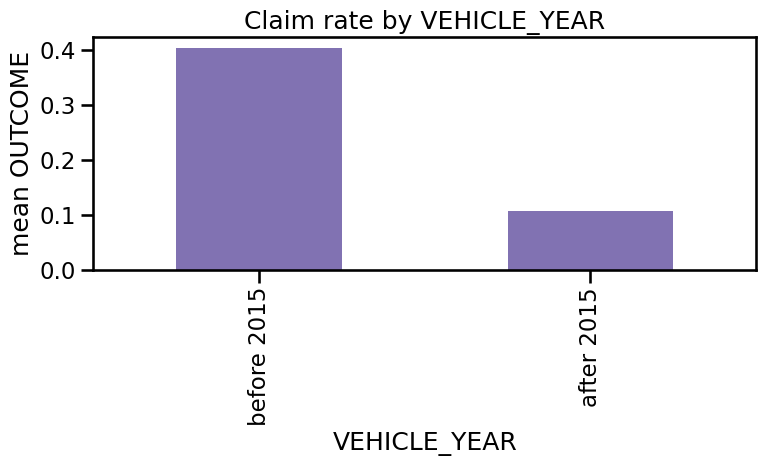

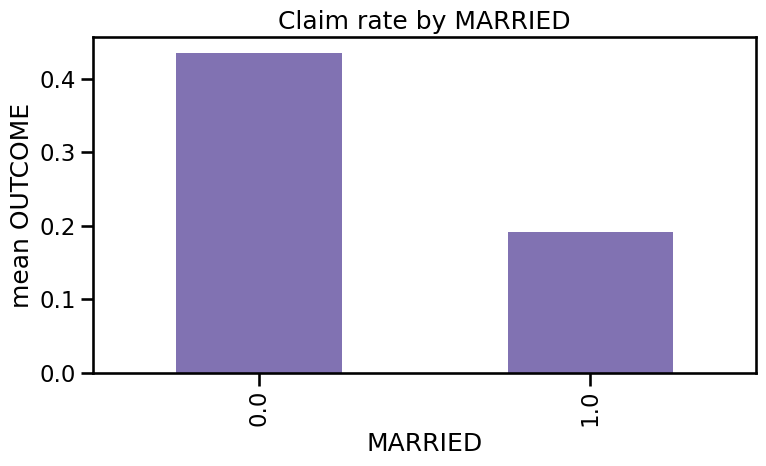

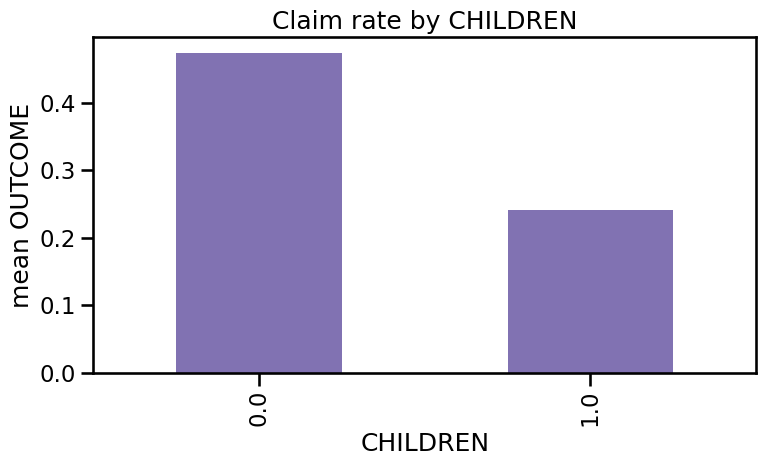

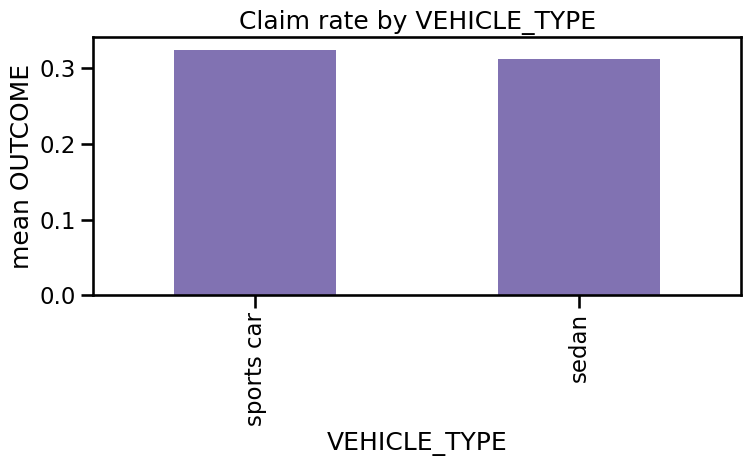

In [8]:
for c in cat_cols:
    rate = df.groupby(c)['OUTCOME'].mean().sort_values(ascending=False)
    ax = rate.plot(kind='bar', color='#8172b2')
    ax.set_title(f'Claim rate by {c}')
    ax.set_ylabel('mean OUTCOME')
    plt.tight_layout()
    plt.show()


## Split and preprocessing plan
- Drop `ID` (identifier).
- Keep sensitive cols (`GENDER`, `RACE`) for audit only.
- Target-encode `POSTAL_CODE` with cross-fitting.
- OHE remaining categoricals; impute missing values.
- Scale numerics for Logistic Regression (RF is insensitive but harmless).


In [9]:
dfm = df.copy()
if 'ID' in dfm.columns:
    dfm = dfm.drop(columns=['ID'])

# exclude sensitive features from training
train_exclude = ['GENDER', 'RACE']

X = dfm.drop(columns=['OUTCOME'])
y = dfm['OUTCOME']

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_df = X_train_df.copy()
X_test_df = X_test_df.copy()


### Cross‑fitted target encoding for POSTAL_CODE
We encode `POSTAL_CODE` into a numeric risk score (smoothed mean `OUTCOME`) learned on train folds, then map test using the full-train mapping.


In [10]:
from sklearn.model_selection import StratifiedKFold

def target_encode_crossfit(X, y, col, n_splits=5, smoothing=50):
    X = X.copy()
    global_mean = float(y.mean())
    te_col = np.zeros(len(X), dtype=float)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for tr, va in skf.split(X, y):
        df_tr = pd.DataFrame({col: X.iloc[tr][col].astype('object').values, 'y': y.iloc[tr].values})
        stats = df_tr.groupby(col)['y'].agg(['mean','count'])
        score = (stats['count'] * stats['mean'] + smoothing * global_mean) / (stats['count'] + smoothing)
        mapped = X.iloc[va][col].astype('object').map(score).astype(float).fillna(global_mean).to_numpy()
        te_col[va] = mapped
    df_full = pd.DataFrame({col: X[col].astype('object').values, 'y': y.values})
    stats_full = df_full.groupby(col)['y'].agg(['mean','count'])
    score_full = (stats_full['count'] * stats_full['mean'] + smoothing * global_mean) / (stats_full['count'] + smoothing)
    return te_col, score_full, global_mean

if 'POSTAL_CODE' in X_train_df.columns:
    te_train, te_map, te_global = target_encode_crossfit(X_train_df, y_train, 'POSTAL_CODE', n_splits=5, smoothing=50)
    X_train_df['POSTAL_CODE_TE'] = te_train
    X_test_df['POSTAL_CODE_TE'] = (
        X_test_df['POSTAL_CODE'].astype('object').map(te_map).astype(float).fillna(te_global).values
    )
    X_train_df = X_train_df.drop(columns=['POSTAL_CODE'])
    X_test_df = X_test_df.drop(columns=['POSTAL_CODE'])


### Build preprocessing for models
- Numeric: impute median, scale


In [11]:
# Determine columns
X_train_proc = X_train_df.drop(columns=[c for c in train_exclude if c in X_train_df.columns])
X_test_proc  = X_test_df.drop(columns=[c for c in train_exclude if c in X_test_df.columns])

cat_cols = X_train_proc.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_proc.select_dtypes(include=['int64','float64']).columns.tolist()

# ensure POSTAL_CODE_TE stays numeric
if 'POSTAL_CODE_TE' in X_train_proc.columns and 'POSTAL_CODE_TE' not in num_cols:
    num_cols.append('POSTAL_CODE_TE')

# mean for bell-shaped vars; median for the rest
mean_cols = [c for c in ['CREDIT_SCORE', 'ANNUAL_MILEAGE'] if c in X_train_proc.columns]
med_cols  = [c for c in num_cols if c not in mean_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('num_mean', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), mean_cols),
        ('num_med', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), med_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ],
    remainder='drop'
)

print('Numeric (mean):', mean_cols)
print('Numeric (median):', med_cols)
print('Categorical:', cat_cols)

Numeric (mean): ['CREDIT_SCORE', 'ANNUAL_MILEAGE']
Numeric (median): ['VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'POSTAL_CODE_TE']
Categorical: ['AGE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME', 'VEHICLE_YEAR', 'VEHICLE_TYPE']


## Model 1: Logistic Regression (baseline)


In [13]:
logreg = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=2000, solver='lbfgs'))
])

logreg.fit(X_train_proc, y_train)
probs_lr = logreg.predict_proba(X_test_proc)[:,1]
pred_lr = (probs_lr >= 0.5).astype(int)

print(f"Logistic — ROC-AUC: {roc_auc_score(y_test, probs_lr):.3f}")
print(f"Logistic — PR-AUC : {average_precision_score(y_test, probs_lr):.3f}")
print(f"Logistic — Accuracy: {accuracy_score(y_test, pred_lr):.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, pred_lr))
print("Report:\n", classification_report(y_test, pred_lr, digits=3))


Logistic — ROC-AUC: 0.906
Logistic — PR-AUC : 0.812
Logistic — Accuracy: 0.842
Confusion matrix:
 [[1224  149]
 [ 168  459]]
Report:
               precision    recall  f1-score   support

         0.0      0.879     0.891     0.885      1373
         1.0      0.755     0.732     0.743       627

    accuracy                          0.842      2000
   macro avg      0.817     0.812     0.814      2000
weighted avg      0.840     0.842     0.841      2000



## Model 2: Random Forest


In [15]:
rf = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train_proc, y_train)
probs_rf = rf.predict_proba(X_test_proc)[:,1]
pred_rf = (probs_rf >= 0.5).astype(int)

print(f"RF — ROC-AUC: {roc_auc_score(y_test, probs_rf):.3f}")
print(f"RF — PR-AUC : {average_precision_score(y_test, probs_rf):.3f}")
print(f"RF — Accuracy: {accuracy_score(y_test, pred_rf):.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, pred_rf))
print("Report:\n", classification_report(y_test, pred_rf, digits=3))


RF — ROC-AUC: 0.897
RF — PR-AUC : 0.787
RF — Accuracy: 0.829
Confusion matrix:
 [[1193  180]
 [ 162  465]]
Report:
               precision    recall  f1-score   support

         0.0      0.880     0.869     0.875      1373
         1.0      0.721     0.742     0.731       627

    accuracy                          0.829      2000
   macro avg      0.801     0.805     0.803      2000
weighted avg      0.830     0.829     0.830      2000



## Conclusion
- Both models perform well .
- Logistic Regression (LR): ROC-AUC 0.906, PR-AUC 0.812, Accuracy 0.842.
  - Positives: precision 0.755, recall 0.732, TP=459, FP=149, FN=168, TN=1224.
- Random Forest (RF): ROC-AUC 0.897, PR-AUC 0.787, Accuracy 0.829.
  - Positives: precision 0.721, recall 0.742, TP=465, FP=180, FN=162, TN=1193.

What this means:
- RF finds 6 more true claims (465 vs 459) but creates 31 more false alarms (180 vs 149).
- LR offers better ranking (ROC/PR-AUC), higher precision, and fewer false positives; RF offers slightly higher recall.
